# Machine Learning in the NBA Draft 
# by Tim Krumwiede

## The Wrangling Process

### Table of Contents
[1. Introduction](#intro)

[2. Draft Data](#draft)

[3. College Player Data](#player)

[4. College Team Data](#team)

<a id='draft'></a>

<a id='intro'></a>

### Introduction

My goal for this project is to build a machine learning pipeline for predicting the long-term success of a college player in the NBA. I see this as a drafting tool for NBA teams to use in informing their draft choices. Therefore, the training data will only be data available for particular player during their college career.

This is a supervised regression problem, so my training set will only include players that actually played in the NBA. I will also only use players that played in college after the 3-point shot was adopted, since that is such an important aspect of the game today.

After researching other similar projects online, I've decided to use three main sources of data: draft data from https://www.basketball-reference.com/play-index/draft_finder.cgi, individual college stats from www.sports-reference.com/cbb, and team college stats also from www.sports-reference.com/cbb.

### Draft Data

I'll start by loading the modules I'm going to use later.

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns

#this is an api that can be used to import data from sports-reference.com
from sportsreference.ncaab.roster import Roster as ncaa_roster 
from sportsreference.ncaab.teams import Teams as ncaa_teams

from IPython.display import clear_output

I was mildly frustrated with exporting data from the basketball-reference draft finder tool. Only one page of a search (100 results) can be exported at a time. I flirted with the idea of doing some kind of web scraping, but ultimately just downloaded each page by hand and appended them all into one excel file: draft.csv. Looking back, I should have better utilized bbref's draft finder tool to filter out players that never played in the NBA, but I'm not going to go back and do it now.

I was mildly frustrated with exporting data from the basketball-reference draft finder tool. Only one page of a search (100 results) can be exported at a time. I flirted with the idea of doing some kind of web scraping, but ultimately just downloaded each page by hand and appended them all into one csv file: draft.csv. Looking back, I should have better utilized bbref's draft finder tool to filter out players that never played in the NBA, but I'm not going to go back and do it now.

In [2]:
draft_data=pd.read_csv('draft.csv')#import csv file
draft_data.head()#display top 5 rows

,Rk,Year,Lg,Rd,Pk,Tm,Player,Age,Pos,Born,...,TRB,AST,STL,BLK,FG%,2P%,3P%,FT%,WS,WS/48
0,1.0,2018.0,NBA,1.0,1.0,PHO,Deandre Ayton,19.338,C,bs,...,10.3,1.8,0.9,0.9,0.585,0.588,0.000,0.746,5.8,0.128
1,2.0,2018.0,NBA,1.0,2.0,SAC,Marvin Bagley,19.104,F,us,...,7.6,1.0,0.5,1.0,0.504,0.534,0.313,0.691,3.6,0.110
2,3.0,2018.0,NBA,1.0,4.0,MEM,Jaren Jackson,18.284,F,us,...,4.7,1.1,0.9,1.4,0.506,0.553,0.359,0.766,3.3,0.105
3,4.0,2018.0,NBA,1.0,5.0,DAL,Trae Young,19.280,G,us,...,3.7,8.1,0.9,0.2,0.418,0.477,0.324,0.829,3.3,0.062
4,5.0,2018.0,NBA,1.0,6.0,ORL,Mohamed Bamba,20.045,C,us,...,5.0,0.8,0.3,1.4,0.481,0.555,0.300,0.587,1.7,0.106


In [3]:
draft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3088 entries, 0 to 3087
Data columns (total 26 columns):
Rk         3086 non-null float64
Year       3086 non-null float64
Lg         3086 non-null object
Rd         3086 non-null float64
Pk         3086 non-null float64
Tm         3086 non-null object
Player     3086 non-null object
Age        1838 non-null float64
Pos        1838 non-null object
Born       1838 non-null object
College    3086 non-null object
From       1809 non-null float64
To         1809 non-null float64
G          1809 non-null float64
MP         1809 non-null float64
PTS        1809 non-null float64
TRB        1809 non-null float64
AST        1809 non-null float64
STL        1809 non-null float64
BLK        1809 non-null float64
FG%        1804 non-null float64
2P%        1802 non-null float64
3P%        1635 non-null float64
FT%        1768 non-null float64
WS         1809 non-null float64
WS/48      1808 non-null float64
dtypes: float64(20), object(6)
memory usa

Really all I need right now from this data is a list of college players that played in the NBA, their colleges and the year they were drafted. The columns "Rd", "Pk", and "Tm" refer to the order in which players were drafted and by which team, so I don't need those. The basketball stats at the bottom all refer to players' performance in the NBA, so I don't want that either (at least not yet), though I am going to use Games Played ("G") to filter out those who didn't end up actually playing.

In [4]:
draft_data=draft_data[draft_data.G > 0]#players who played at least one game in the NBA
draft_data=draft_data[['Player','Year','Age','Pos','College']]#these are the columns I can use
draft_data['Year']=draft_data.Year.astype(int)#recasting Year as an int
draft_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1809 entries, 0 to 3053
Data columns (total 5 columns):
Player     1809 non-null object
Year       1809 non-null int32
Age        1809 non-null float64
Pos        1809 non-null object
College    1809 non-null object
dtypes: float64(1), int32(1), object(3)
memory usage: 77.7+ KB


<a id='player'></a>

### College Player Data

I'm going to use the sports-reference api I loaded above to look up college stats for each player in draft_data. The documentation can be found at https://sportsreference.readthedocs.io/en/stable/ncaab.html.

There's a big problem though: looking up a player requires knowing either the player's code or the college abbreviation used by the API. After looking through the list of college abbreviations, I was able to decipher most of the rules for taking the full name of a college (which is the value in the "College" column of draft data) and converting it to the college abbreviation we need for the API.

In [93]:
def to_college_code(colleges): #colleges is expected to be of the pandas series type
    college_code=colleges.str.replace('University','')# strip out substring 'University'
    college_code=college_code.str.replace('of ','')#More operations that convert to the college abbreviation used by the API
    college_code=college_code.str.replace(',','')#...
    college_code=college_code.str.replace('.','')
    college_code=college_code.str.replace('\'','')
    college_code=college_code.str.replace('NCAA','')
    college_code=college_code.str.replace('College','')
    college_code=college_code.str.strip()
    college_code=college_code.str.upper()
    college_code=college_code.str.replace('   ','-')
    college_code=college_code.str.replace('  ','-')
    college_code=college_code.str.replace(' ','-')
    college_code=college_code.str.replace('AT-','')
    college_code=college_code.str.replace('CALIFORNIA-STATE','CAL-STATE')
    college_code=college_code.str.replace('A&M','AM')
    college_code=college_code.str.replace('THE-','')
    
    #the operations above cover the vast majority of cases, but there are still some holdouts
    #I'm covering exceptions by slicing out the exception rows and assigning the correct abbreviation manually
    for i in college_code[college_code=='CALIFORNIA-LOS-ANGELES'].index:
        college_code[i]='UCLA'

    for i in college_code[college_code=='ILLINOIS-URBANA-CHAMPAIGN'].index:
        college_code[i]='ILLINOIS'
    
    for i in college_code[college_code=='NEVADA-RENO'].index:
        college_code[i]='NEVADA'

    for i in college_code[college_code=='GEORGIA-INSTITUTE-TECHNOLOGY'].index:
        college_code[i]='GEORGIA-TECH'    
    
    for i in college_code[colleges=='Boston College'].index:
        college_code[i]='BOSTON-COLLEGE'    
    
    for i in college_code[colleges=='Boston University'].index:
        college_code[i]='BOSTON-UNIVERSITY'  
    
    for i in college_code[college_code=='VIRGINIA-POLYTECHNIC-INSTITUTE-AND-STATE'].index:
        college_code[i]='VIRGINIA-TECH'
    
    for i in college_code[college_code=='TEXAS-AUSTIN'].index:
        college_code[i]='TEXAS'  

    for i in college_code[college_code=='ST-JOHNS'].index:
        college_code[i]='ST-JOHNS-NY' 
    
    for i in college_code[colleges=='University of Miami'].index:
        college_code[i]='MIAMI-FL'    
    
    for i in college_code[colleges=='Miami University'].index:
        college_code[i]='MIAMI-OH' 
    
    for i in college_code[college_code=='LOYOLA-CHICAGO'].index:
        college_code[i]='LOYOLA-IL'  

    for i in college_code[college_code=='LOYOLA-IN-MARYLAND'].index:
        college_code[i]='LOYOLA-MD' 
    
    for i in college_code[college_code=='FLORIDA-AGRICULTURAL-AND-MECHANICAL'].index:
        college_code[i]='FLORIDA-AM' 
    
    for i in college_code[college_code=='CAL-STATE-FRESNO'].index:
        college_code[i]='FRESNO-STATE' 
    
    for i in college_code[college_code=='CAL-STATE-LONG-BEACH'].index:
        college_code[i]='LONG-BEACH-STATE' 
    
    for i in college_code[college_code=='TENNESSEE-TECHNOLOGICAL'].index:
        college_code[i]='TENNESSEE-TECH' 
    
    for i in college_code[college_code=='INDIANA--PURDUE-INDIANAPOLIS'].index:
        college_code[i]='IUPUI' 
    
    for i in college_code[college_code=='SAINT-MARYS-CALIFORNIA'].index:
        college_code[i]='SAINT-MARYS-CA' 
    
    for i in college_code[college_code=='MIDDLE-TENNESSEE-STATE'].index:
        college_code[i]='MIDDLE-TENNESSEE' 
    
    for i in college_code[college_code=='AUSTIN-PEAY-STATE'].index:
        college_code[i]='AUSTIN-PEAY'  
    
    for i in college_code[college_code=='MASSACHUSETTS-AMHERST'].index:
        college_code[i]='MASSACHUSETTS'  
    
    for i in college_code[college_code=='PENNSYLVANIA-STATE'].index:
        college_code[i]='PENN-STATE'
    
    for i in college_code[college_code=='LONG-ISLAND'].index:
        college_code[i]='LONG-ISLAND-UNIVERSITY'
    
    for i in college_code[college_code=='UNITED-STATES-NAVAL-ACADEMY'].index:
        college_code[i]='NAVY'
        
    return college_code #return the new series


In [6]:
#creating a new column with the college abbreviations
draft_data['college_code'] = to_college_code(draft_data.College)

In [7]:
draft_data.head()

,Player,Year,Age,Pos,College,college_code
0,Deandre Ayton,2018,19.338,C,University of Arizona,ARIZONA
1,Marvin Bagley,2018,19.104,F,Duke University,DUKE
2,Jaren Jackson,2018,18.284,F,Michigan State University,MICHIGAN-STATE
3,Trae Young,2018,19.280,G,University of Oklahoma,OKLAHOMA
4,Mohamed Bamba,2018,20.045,C,University of Texas at Austin,TEXAS


Alright, now we're going to use the sports-reference API to add stats for each player in draft_data. Recall that I loaded a module from the API as ncaa_roster. ncaa_roster returns a roster object for a specified team and year. Each roster object consists of player objects which each have a dataframe attribute containing college statistics fro that player. There is probably a better way to do this, but I'm going to loop through each player in draft_data, get the associated roster object, loop through the players to find the desired player, and extract stats from that player's dataframe.

WARNING! I'm not sure why but this takes a loooooong time to run. Something about the API is not optimized for this repeated queries like this.

There's an interesting problem in deciding which stats to import. College players all stay in college for varying numbers of years. Many of the best NBA prospects only go to college for one year before joining the NBA. Others take more time, often the full four years, to showcase their potential worth to NBA scouts. 

The NBA draft machine-learning projects I've found while researching this project have all dealt with this in different ways. Some use only the player's last year in the NBA. Others use their college career averages instead. 

One project didn't want to throw away any data, so the author used the stats for every year. However, since machine learning algortihms need training examples to all have the same columns, each year for a player became a distinct row in the dataset. While I like the idea of using multiple years of data, I don't like this solution because a) players who played longer in college become over-represented and b) multiple instances of the same player are treated as independent training examples.

Here's what I want to try. Each player is represented by one row, but there will be columns for the player's first year stats and other columns for the player's stats in his last year. I like this because now you can a player's growth in each row. Career stats might be nice since they are over a larger timeframe, but NBA teams might very well be interested in a player who starts his college career slow but shows strong growth over the years, indicating that he could possibly keep growing at a fast pace in the NBA as well. 

I'm going to try this idea out and come back to it after to analyze how helpful it was.


Enough commentary, let's do it.

In [57]:
sample_player_df=ncaa_roster(team='DUKE').players[1].dataframe#One player's dataframe
ncaa_columns=list(sample_player_df.columns)#the columns
cfirst_columns=['cfirst_' + col for col in ncaa_columns]#make a list for first year stats
clast_columns=['clast_' + col for col in ncaa_columns]#and one for last year stats

In [9]:
data=pd.concat([draft_data,pd.DataFrame(columns=cfirst_columns)],sort=False)#add new columns to draft_data and call the result data
data=pd.concat([data,pd.DataFrame(columns=clast_columns)],sort=False)


In [10]:
data.Year=data.Year.astype(int)#I'm not sure why but the change from draft_data to data made the Year column floats

,Player,Year,Age,Pos,College,college_code,cfirst_assist_percentage,cfirst_assists,cfirst_block_percentage,cfirst_blocks,...,clast_true_shooting_percentage,clast_turnover_percentage,clast_turnovers,clast_two_point_attempts,clast_two_point_percentage,clast_two_pointers,clast_usage_percentage,clast_weight,clast_win_shares,clast_win_shares_per_40_minutes
0,Deandre Ayton,2018,19.338,C,University of Arizona,ARIZONA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Marvin Bagley,2018,19.104,F,Duke University,DUKE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Jaren Jackson,2018,18.284,F,Michigan State University,MICHIGAN-STATE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Trae Young,2018,19.280,G,University of Oklahoma,OKLAHOMA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mohamed Bamba,2018,20.045,C,University of Texas at Austin,TEXAS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here's the big one.

In [12]:
for r in data.iterrows():#iterate over all rows (players) in data
    i=r[0]# index
    row=r[1] #row values
    clear_output(wait=True)
    print(i)# while running, this tells us where the loop is.
    try:#exceptions come up when ncaa_roster can't find the right college page
        for player in ncaa_roster(team=row.college_code,year=row.Year).players:#loop through the roster's player objects
            if player.name:#sometimes rosters have null slots which stop the loop. This prevents that
                if row.Player in player.name:#I use in because there are suffixes that show up sometimes
                    first=player.dataframe.iloc[0,:]#first row in dataframe is the first year stats
                    first.index=['cfirst_'+s for s in list(first.keys())]#change keys of first to match columns in data
                    data.loc[i,cfirst_columns]=first#set first year columns in data
                    last=player.dataframe.iloc[-2,:]#the -1 index of the player's df is career stats, so -2 is last year stats
                    last.index=['clast_'+s for s in list(last.keys())]#change keys of last to match columns in data
                    data.loc[i,clast_columns]=last#set last year columns in data
                    break #once the player is found, stop the loop to save time
        
        #there are a few instances of players who weren't drafted until a year AFTER they finished college.
        for player in ncaa_roster(team=row.college_code,year=(row.Year-1)).players:
            if player.name:
                if row.Player in player.name:
                    first=player.dataframe.iloc[0,:]
                    first.index=['cfirst_'+s for s in list(first.keys())]
                    data.loc[i,cfirst_columns]=first
                    last=player.dataframe.iloc[-2,:]
                    last.index=['clast_'+s for s in list(last.keys())]
                    data.loc[i,clast_columns]=last
                    break
                
    except:#exceptions show up when the API can't find the right college. Just ignore them and leave the rows blank
        pass

3053


In [13]:
#save to file so we don't have to go through that again
data.to_csv('raw_data.csv',index=False,header=True)

As mentioned in the comments above, some players' colleges can't be found in the API. Also, in some cases, the in statement used to match names doesn't work. Here I'll do some work to find these missing players, mainly by extracting just last name and then trying again.

In [58]:
data=pd.read_csv('raw_data.csv',index_col=False)
missing_players=data[data.clast_points.isnull()].Player
missing_players.describe()

count             93
unique            93
top       Greg Grant
freq               1
Name: Player, dtype: object

In [59]:
for i in missing_players.index:
    clear_output(wait=True)
    print(i)
    row=data.loc[i,:]
    lastname=row.Player
    #strip off suffixes
    if ' Jr.' in lastname:
        lastname=lastname.replace(' Jr.','')
    elif ' III' in lastname:
        lastname=lastname.replace(' III','')
    lastname=lastname.split(' ')[-1] #this should extract just the last name
    
    try:  #we'll try to get their stats again
        for player in ncaa_roster(team=row.college_code,year=row.Year).players:
            if player.name:
                if lastname in player.name: #this team I'm only checking if the last name is present
                    first=player.dataframe.iloc[0,:]
                    first.index=['cfirst_'+s for s in list(first.keys())]
                    data.loc[i,cfirst_columns]=first
                    last=player.dataframe.iloc[-2,:]
                    last.index=['clast_'+s for s in list(last.keys())]
                    data.loc[i,clast_columns]=last
                    break

    except:
        pass
#let's see how we did
missing_players=data[data.clast_points.isnull()].Player
missing_players.describe()

1798


count               76
unique              76
top       Terry Porter
freq                 1
Name: Player, dtype: object

Ok great, that helped with some. I'm just going to drop the rest.

In [60]:
data=data.drop(missing_players.index)

Oh, and it looks like even though the NBA adopted the 3-point shot in 1981, the NCAA didn't until later. We'll have to drop some of the earlier rows.

In [61]:
data=data[data.Year>1987]

And there are a few useless or redundant columns that we can clean up, too.

In [62]:
data=data.drop(columns=['clast_conference','clast_height','clast_player_id','clast_position','clast_team_abbreviation','clast_weight'])
data=data.drop(columns=['cfirst_conference','cfirst_height','cfirst_player_id','cfirst_position','cfirst_team_abbreviation','cfirst_weight'])

for s in ['clast_conference','clast_height','clast_player_id','clast_position','clast_team_abbreviation','clast_weight']:
    clast_columns.remove(s)
for s in ['cfirst_conference','cfirst_height','cfirst_player_id','cfirst_position','cfirst_team_abbreviation','cfirst_weight']:
    cfirst_columns.remove(s)

Now it's time to look at missing values. Each column needs to be treated differently, so first I'm going to check on the missing values per column.

In [63]:
cfirst_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, cfirst_columns))

cfirst_missing={}
for col in cfirst_missing_cols:
    cfirst_missing[col]=data[col].isnull().sum()
cfirst_missing

{'cfirst_assist_percentage': 740,
 'cfirst_assists': 2,
 'cfirst_block_percentage': 740,
 'cfirst_blocks': 2,
 'cfirst_box_plus_minus': 1018,
 'cfirst_defensive_box_plus_minus': 1018,
 'cfirst_defensive_rebound_percentage': 980,
 'cfirst_defensive_rebounds': 642,
 'cfirst_defensive_win_shares': 462,
 'cfirst_effective_field_goal_percentage': 86,
 'cfirst_field_goal_attempts': 1,
 'cfirst_field_goal_percentage': 1,
 'cfirst_field_goals': 1,
 'cfirst_free_throw_attempt_rate': 1,
 'cfirst_free_throw_attempts': 1,
 'cfirst_free_throw_percentage': 5,
 'cfirst_free_throws': 1,
 'cfirst_games_played': 1,
 'cfirst_games_started': 330,
 'cfirst_minutes_played': 33,
 'cfirst_offensive_box_plus_minus': 1018,
 'cfirst_offensive_rebound_percentage': 980,
 'cfirst_offensive_rebounds': 642,
 'cfirst_offensive_win_shares': 462,
 'cfirst_personal_fouls': 40,
 'cfirst_player_efficiency_rating': 990,
 'cfirst_points': 1,
 'cfirst_points_produced': 980,
 'cfirst_steal_percentage': 971,
 'cfirst_steals': 2

Many of these are missing only one value. On closer inspection, there is a single player in the set who did not play at all in his first year in college. I'm going to drop him.

In [64]:
first_missing=data[data.cfirst_field_goal_attempts.isnull()].index

In [65]:
data=data.drop(first_missing)

cfirst_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, cfirst_columns))

cfirst_missing={}
for col in cfirst_missing_cols:
    cfirst_missing[col]=data[col].isnull().sum()
cfirst_missing

{'cfirst_assist_percentage': 739,
 'cfirst_assists': 1,
 'cfirst_block_percentage': 739,
 'cfirst_blocks': 1,
 'cfirst_box_plus_minus': 1017,
 'cfirst_defensive_box_plus_minus': 1017,
 'cfirst_defensive_rebound_percentage': 979,
 'cfirst_defensive_rebounds': 641,
 'cfirst_defensive_win_shares': 461,
 'cfirst_effective_field_goal_percentage': 85,
 'cfirst_free_throw_percentage': 4,
 'cfirst_games_started': 329,
 'cfirst_minutes_played': 32,
 'cfirst_offensive_box_plus_minus': 1017,
 'cfirst_offensive_rebound_percentage': 979,
 'cfirst_offensive_rebounds': 641,
 'cfirst_offensive_win_shares': 461,
 'cfirst_personal_fouls': 39,
 'cfirst_player_efficiency_rating': 989,
 'cfirst_points_produced': 979,
 'cfirst_steal_percentage': 970,
 'cfirst_steals': 1,
 'cfirst_three_point_attempt_rate': 85,
 'cfirst_three_point_attempts': 85,
 'cfirst_three_point_percentage': 311,
 'cfirst_three_pointers': 85,
 'cfirst_total_rebound_percentage': 740,
 'cfirst_turnover_percentage': 46,
 'cfirst_turnovers'

Before making any other decisions, I really want to know how these missing values are distributed per column. If a column has all of its missing values at the bottom of the dataframe, that should mean that the statistic simply wasn't tracked before a certain year. If the missing values are scattered throughout, those might be values I could fill.

I really like using a seaborn heat map to see where the missing values are. Black in these plots indicate a non-missing value.

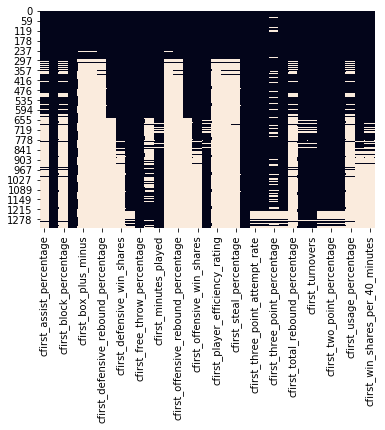

In [66]:
sns.heatmap(data[cfirst_missing_cols].isnull(), cbar=False)

There is a small group of rows near the bottom that are missing many of even basic statistics. I'll drop these (using missing values in the two_pointers column to find them).

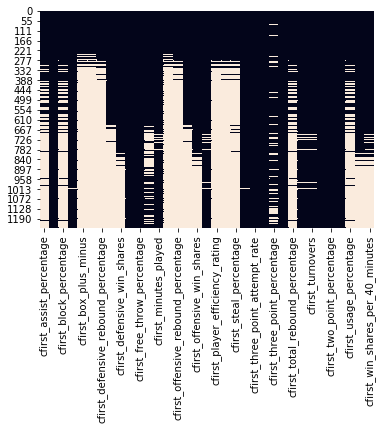

In [67]:
data=data[~data.cfirst_two_pointers.isnull()]
sns.heatmap(data[cfirst_missing_cols].isnull(), cbar=False)

The three_point_percentage column is one in which the missing values are distributed across the entire column. After some inspecting some of these players, it looks like they are players with 0 three point attempts and therefore their percentage is 0/0. I'm going to fill these values with 0 since a player who never takes even a single three point shot is probably not going to make any had they took those shots.

In [68]:
for i in data[data.cfirst_three_point_percentage.isnull()].index:
    data.loc[i,'cfirst_three_point_percentage']=0

In [69]:
cfirst_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, cfirst_columns))

cfirst_missing={}
for col in cfirst_missing_cols:
    cfirst_missing[col]=data[col].isnull().sum()
cfirst_missing

{'cfirst_assist_percentage': 657,
 'cfirst_block_percentage': 657,
 'cfirst_blocks': 1,
 'cfirst_box_plus_minus': 932,
 'cfirst_defensive_box_plus_minus': 932,
 'cfirst_defensive_rebound_percentage': 894,
 'cfirst_defensive_rebounds': 556,
 'cfirst_defensive_win_shares': 376,
 'cfirst_free_throw_percentage': 3,
 'cfirst_games_started': 306,
 'cfirst_minutes_played': 32,
 'cfirst_offensive_box_plus_minus': 932,
 'cfirst_offensive_rebound_percentage': 894,
 'cfirst_offensive_rebounds': 556,
 'cfirst_offensive_win_shares': 376,
 'cfirst_personal_fouls': 39,
 'cfirst_player_efficiency_rating': 904,
 'cfirst_points_produced': 894,
 'cfirst_steal_percentage': 885,
 'cfirst_steals': 1,
 'cfirst_total_rebound_percentage': 658,
 'cfirst_turnover_percentage': 40,
 'cfirst_turnovers': 40,
 'cfirst_usage_percentage': 658,
 'cfirst_win_shares': 376,
 'cfirst_win_shares_per_40_minutes': 408}

After a little more research, a couple more columns' missing values can justifiably be filled with zeros.

In [70]:
for i in data[data.cfirst_blocks.isnull()].index:
    data.loc[i,'cfirst_blocks']=0

for i in data[data.cfirst_free_throw_percentage.isnull()].index:
    data.loc[i,'cfirst_free_throw_percentage']=0
    
for i in data[data.cfirst_steals.isnull()].index:
    data.loc[i,'cfirst_steals']=0

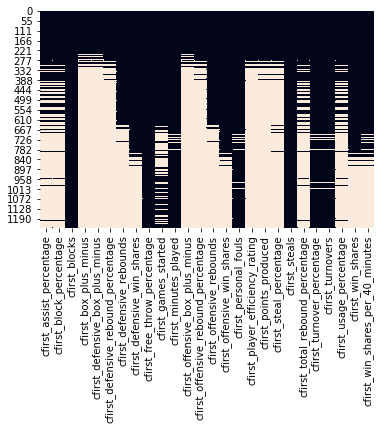

In [71]:
sns.heatmap(data[cfirst_missing_cols].isnull(), cbar=False)

As you can see, there are still many missing values. However, I'm going to stop working on the first-year stats for now and follow the same steps as above for last-year stats.

In the end, many of these columns and rows will be dropped. I think there's enough of a difference, though, in the statistics that are tracked now compared to 30 years ago, that it's worth building a couple different datasets: one with more columns dropped to keep as many rows as possible (skinnier) and one with more rows dropped to keep as many features as possible (fatter). I'll make these decisions once all the data is ready.

The next few cells, then, are the same as above, but for last-year stats.

In [72]:
clast_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, clast_columns))

clast_missing={}
for col in clast_missing_cols:
    clast_missing[col]=data[col].isnull().sum()
clast_missing

{'clast_assist_percentage': 598,
 'clast_block_percentage': 598,
 'clast_box_plus_minus': 853,
 'clast_defensive_box_plus_minus': 853,
 'clast_defensive_rebound_percentage': 806,
 'clast_defensive_rebounds': 475,
 'clast_defensive_win_shares': 275,
 'clast_games_started': 289,
 'clast_minutes_played': 44,
 'clast_offensive_box_plus_minus': 853,
 'clast_offensive_rebound_percentage': 806,
 'clast_offensive_rebounds': 475,
 'clast_offensive_win_shares': 275,
 'clast_personal_fouls': 47,
 'clast_player_efficiency_rating': 853,
 'clast_points_produced': 806,
 'clast_steal_percentage': 803,
 'clast_three_point_attempt_rate': 1,
 'clast_three_point_attempts': 1,
 'clast_three_point_percentage': 124,
 'clast_total_rebound_percentage': 598,
 'clast_turnover_percentage': 47,
 'clast_turnovers': 47,
 'clast_two_point_attempts': 1,
 'clast_two_point_percentage': 1,
 'clast_usage_percentage': 598,
 'clast_win_shares': 275,
 'clast_win_shares_per_40_minutes': 318}

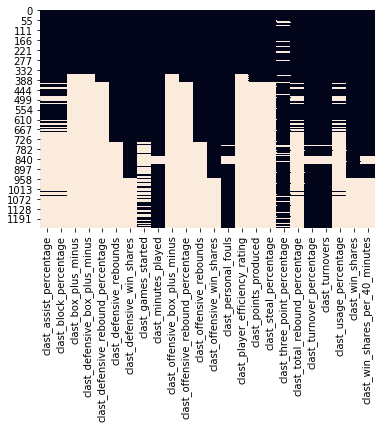

In [73]:
data=data[~data.clast_two_point_percentage.isnull()]

clast_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, clast_columns))

clast_missing={}
for col in clast_missing_cols:
    clast_missing[col]=data[col].isnull().sum()
sns.heatmap(data[clast_missing_cols].isnull(), cbar=False)

In [74]:
for i in data[data.clast_three_point_percentage.isnull()].index:
    data.loc[i,'clast_three_point_percentage']=0

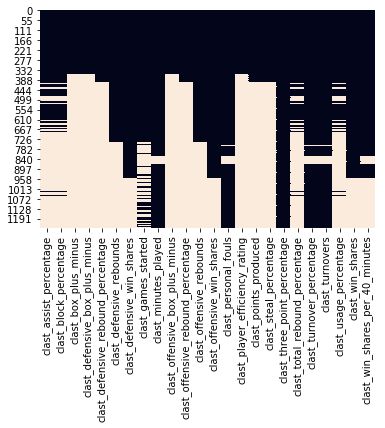

In [75]:
sns.heatmap(data[clast_missing_cols].isnull(), cbar=False)

In [76]:
clast_missing_cols=list(filter(lambda col: data[col].isnull().sum()>0, clast_columns))

clast_missing={}
for col in clast_missing_cols:
    clast_missing[col]=data[col].isnull().sum()
clast_missing

{'clast_assist_percentage': 597,
 'clast_block_percentage': 597,
 'clast_box_plus_minus': 852,
 'clast_defensive_box_plus_minus': 852,
 'clast_defensive_rebound_percentage': 805,
 'clast_defensive_rebounds': 474,
 'clast_defensive_win_shares': 274,
 'clast_games_started': 288,
 'clast_minutes_played': 44,
 'clast_offensive_box_plus_minus': 852,
 'clast_offensive_rebound_percentage': 805,
 'clast_offensive_rebounds': 474,
 'clast_offensive_win_shares': 274,
 'clast_personal_fouls': 47,
 'clast_player_efficiency_rating': 852,
 'clast_points_produced': 805,
 'clast_steal_percentage': 802,
 'clast_total_rebound_percentage': 597,
 'clast_turnover_percentage': 47,
 'clast_turnovers': 47,
 'clast_usage_percentage': 597,
 'clast_win_shares': 274,
 'clast_win_shares_per_40_minutes': 317}

In [77]:
data.to_csv('player_data.csv',index=False,header=True)

<a id='team'></a>

### College Team Data

At first I tried to use the API to get team statistics for each player similar to before but that ended up being problematic for several reasons (not using the same abbreviation as before, extremely long runtime, tons of errors, etc.)

After some frustration, I decided it would be easier to download directly from sports-reference.com. Pages such as https://www.sports-reference.com/cbb/seasons/2018-school-stats.html contain the stats of every school in division I college basketball for one season. Note that the stats are partitioned into four pages: basic, advanced, opponent, opponent advanced. However, the opponent stats are only available after 2009, and advanced stats are available only after 1992. 

Since I am very interested in what effect the inclusion of team stats has on the pipeline as a whole, the "skinny" dataset mentioned above will not include any and the "fat" set will have all team and opponent stats. I can also include a "medium" set that has basic and advanced team stats after 1992, hopefully to act as a happy medium between "fat" and "skinny".

One more thing I should mention is that I'm only going to use the team stats for a player's last year in college, presumably the year that they contriubuted most to team success.

In [28]:
#dealing with opponent stats column names
o_columns=pd.read_excel('team_data/2018o.xls',header=1).columns
#we need to rename all of the actual opponent stats, since they have the same names as the team stats
o_columns_rename=['Rk', 'School', 'G', 'W', 'L', 'W-L%', 'SRS', 'SOS', 'W.1', 'L.1',
       'W.2', 'L.2', 'W.3', 'L.3', 'Tm.', 'Opp.', 'Unnamed: 16', 'opp_MP', 'opp_FG',
       'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_FT', 'opp_FTA', 'opp_FT%', 'opp_ORB', 'opp_TRB',
       'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF']
o_columns_merge=['Rk', 'opp_MP', 'opp_FG',
       'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_FT', 'opp_FTA', 'opp_FT%', 'opp_ORB', 'opp_TRB',
       'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF']

In [29]:
#same as above but for advanced opponent stats
ao_columns=pd.read_excel('team_data/2018ao.xls',header=1).columns
ao_columns_rename=['Rk', 'School', 'G', 'W', 'L', 'W-L%', 'SRS', 'SOS', 'W.1', 'L.1',
       'W.2', 'L.2', 'W.3', 'L.3', 'Tm.', 'Opp.', 'Unnamed: 16', 'opp_Pace',
       'opp_ORtg', 'opp_FTr', 'opp_3PAr', 'opp_TS%', 'opp_TRB%', 'opp_AST%', 'opp_STL%', 'opp_BLK%', 'opp_eFG%',
       'opp_TOV%', 'opp_ORB%', 'opp_FT/FGA']
ao_columns_merge=['Rk', 'opp_Pace',
       'opp_ORtg', 'opp_FTr', 'opp_3PAr', 'opp_TS%', 'opp_TRB%', 'opp_AST%', 'opp_STL%', 'opp_BLK%', 'opp_eFG%',
       'opp_TOV%', 'opp_ORB%', 'opp_FT/FGA']

Since I have downloaded all of these sports-reference pages as separate excel files, the next cell will load and merge the files after 2009 into one data set with all college team data.

In [79]:
team_data_fat=pd.read_excel('team_data/2018.xls',header=1)#read in the first file to start
team_data_fat['Year']=2018#add a year column. this will be important for merging to the player data later

temp1=pd.read_excel('team_data/2018a.xls',header=1)#read in advanced stats for 2018
merge_cols_a=list(set(temp1.columns) - set(team_data_fat.columns))+['Rk']#identify columns to merge onto team_data_fat
team_data_fat=team_data_fat.merge(temp1[merge_cols_a] ,
                             how='outer',on='Rk',copy=False)##perform the merge

temp2=pd.read_excel('team_data/2018o.xls',header=1)#same as above but with basic opponent stats
temp2.columns=o_columns_rename #rename columns that are identical to team stats (just append 'opp_' to front)
team_data_fat=team_data_fat.merge(temp2[o_columns_merge] ,
                             how='outer',on='Rk',copy=False)

temp3=pd.read_excel('team_data/2018ao.xls',header=1)#same as above but with advanced opponent stats
temp3.columns=ao_columns_rename
team_data_fat=team_data_fat.merge(temp3[ao_columns_merge] ,
                             how='outer',on='Rk',copy=False)


for i in range(2017,2009,-1): #loop over the rest of the years since 2009
    file='team_data/' + str(i) + '.xls' #define file names
    file_a='team_data/' + str(i) + 'a.xls'
    file_o='team_data/' + str(i) + 'o.xls'
    file_ao='team_data/' + str(i) + 'ao.xls'
    
    temp=pd.read_excel(file,header=1)#read in basic stats
    temp['Year']=i
    temp=temp.merge(pd.read_excel(file_a,header=1)[merge_cols_a],
                             how='outer',on='Rk',copy=False)#merge advanced stats to temp dataframe
    
    temp2=pd.read_excel(file_o,header=1)#read in basic opponent stats
    temp2.columns=o_columns_rename 
    temp=temp.merge(temp2[o_columns_merge] ,
                             how='outer',on='Rk',copy=False)#merge
    
    temp3=pd.read_excel(file_ao,header=1)#read in advanced opponent stats
    temp3.columns=ao_columns_rename
    temp=temp.merge(temp3[ao_columns_merge] ,
                             how='outer',on='Rk',copy=False)#merge
    
    team_data_fat=team_data_fat.append(temp,ignore_index=True,sort=False)# append temp which contains stats for one year to team_data_fat
team_data_fat

,Rk,School,G,W,L,W-L%,SRS,SOS,W.1,L.1,...,opp_3PAr,opp_TS%,opp_TRB%,opp_AST%,opp_STL%,opp_BLK%,opp_eFG%,opp_TOV%,opp_ORB%,opp_FT/FGA
0,1,Abilene Christian,32,16,16,0.500,-9.14,-6.82,8.0,10.0,...,0.374,0.540,50.3,48.1,8.9,7.5,0.499,19.5,28.4,0.298
1,2,Air Force,31,12,19,0.387,-4.31,1.72,6.0,12.0,...,0.431,0.576,51.3,57.2,8.3,10.6,0.549,18.3,27.8,0.234
2,3,Akron,32,14,18,0.438,-6.82,-1.92,6.0,12.0,...,0.401,0.567,50.8,51.1,9.0,11.7,0.532,16.2,27.9,0.277
3,4,Alabama A&M,31,3,28,0.097,-23.97,-8.04,3.0,15.0,...,0.323,0.562,51.8,52.2,11.1,13.8,0.540,14.4,32.1,0.204
4,5,Alabama-Birmingham,33,20,13,0.606,4.90,-0.65,10.0,8.0,...,0.437,0.524,45.2,53.2,10.0,7.7,0.498,15.9,24.6,0.183
5,6,Alabama State,31,8,23,0.258,-18.55,-8.62,8.0,10.0,...,0.352,0.556,52.1,51.4,9.4,9.9,0.519,15.5,34.7,0.319
6,7,Alabama NCAA,36,20,16,0.556,12.34,10.64,8.0,10.0,...,0.379,0.514,49.7,48.7,9.4,10.5,0.478,16.0,30.8,0.250
7,8,Albany (NY),32,22,10,0.688,0.01,-5.41,10.0,6.0,...,0.362,0.533,44.8,53.7,8.2,10.1,0.506,15.2,24.3,0.195
8,9,Alcorn State,32,11,21,0.344,-18.07,-8.60,7.0,11.0,...,0.410,0.541,51.6,57.6,8.9,8.8,0.505,16.0,31.2,0.270
9,10,American,30,6,24,0.200,-14.63,-6.17,3.0,15.0,...,0.325,0.582,54.9,53.1,10.3,11.9,0.549,17.8,30.9,0.291


In [82]:
team_data_fat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 78 columns):
Rk             3125 non-null int64
School         3125 non-null object
G              3125 non-null int64
W              3125 non-null int64
L              3125 non-null int64
W-L%           3125 non-null float64
SRS            3125 non-null float64
SOS            3125 non-null float64
W.1            3117 non-null float64
L.1            3117 non-null float64
W.2            3125 non-null int64
L.2            3125 non-null int64
W.3            3125 non-null int64
L.3            3125 non-null int64
Tm.            3125 non-null int64
Opp.           3125 non-null int64
Unnamed: 16    0 non-null float64
MP             3125 non-null int64
FG             3125 non-null int64
FGA            3125 non-null int64
FG%            3125 non-null float64
3P             3125 non-null int64
3PA            3125 non-null int64
3P%            3125 non-null float64
FT             3125 non-null int64
FTA 

In [84]:
team_data_fat=team_data_fat.drop(columns=['Unnamed: 16'])#this was just a empty column

Here I'm following the same process as above, but this time I include all years since 1993 and do not include opponent stats.

In [86]:
team_data_med=pd.read_excel('team_data/2018.xls',header=1)#start with basic stats for 2018
team_data_med['Year']=2018 #Year column for merging later

temp1=pd.read_excel('team_data/2018a.xls',header=1)#2018 advanced stats
merge_cols_a=list(set(temp1.columns) - set(team_data_med.columns))+['Rk']
team_data_med=team_data_med.merge(temp1[merge_cols_a] ,
                             how='outer',on='Rk',copy=False)#merge




for i in range(2017,1992,-1):#do the same for the rest of the years since 1993
    file='team_data/' + str(i) + '.xls'
    file_a='team_data/' + str(i) + 'a.xls'
    
    temp=pd.read_excel(file,header=1)
    temp['Year']=i
    temp=temp.merge(pd.read_excel(file_a,header=1)[merge_cols_a],
                             how='outer',on='Rk',copy=False)
    
    team_data_med=team_data_med.append(temp,ignore_index=True,sort=False)
team_data_med

,Rk,School,G,W,L,W-L%,SRS,SOS,W.1,L.1,...,3PAr,ORB%,TOV%,FTr,BLK%,AST%,TS%,STL%,eFG%,TRB%
0,1,Abilene Christian,32,16,16,0.500,-9.14,-6.82,8.0,10.0,...,0.350,27.8,17.7,0.309,11.6,55.4,0.549,11.3,0.521,49.7
1,2,Air Force,31,12,19,0.387,-4.31,1.72,6.0,12.0,...,0.431,27.5,16.3,0.318,8.1,60.7,0.527,9.5,0.490,48.7
2,3,Akron,32,14,18,0.438,-6.82,-1.92,6.0,12.0,...,0.467,27.1,17.3,0.319,7.5,52.7,0.547,8.4,0.518,49.2
3,4,Alabama A&M,31,3,28,0.097,-23.97,-8.04,3.0,15.0,...,0.354,29.4,20.9,0.314,3.9,50.5,0.480,5.8,0.450,48.2
4,5,Alabama-Birmingham,33,20,13,0.606,4.90,-0.65,10.0,8.0,...,0.334,31.1,16.5,0.291,11.6,59.3,0.575,7.7,0.545,54.8
5,6,Alabama State,31,8,23,0.258,-18.55,-8.62,8.0,10.0,...,0.347,31.9,16.9,0.352,11.2,41.7,0.496,7.7,0.465,47.9
6,7,Alabama NCAA,36,20,16,0.556,12.34,10.64,8.0,10.0,...,0.355,29.3,17.8,0.419,14.7,50.3,0.550,9.0,0.519,50.3
7,8,Albany (NY),32,22,10,0.688,0.01,-5.41,10.0,6.0,...,0.273,34.9,14.7,0.370,7.9,48.3,0.550,7.0,0.507,55.2
8,9,Alcorn State,32,11,21,0.344,-18.07,-8.60,7.0,11.0,...,0.382,27.1,17.9,0.328,7.7,53.0,0.532,8.8,0.499,48.4
9,10,American,30,6,24,0.200,-14.63,-6.17,3.0,15.0,...,0.439,23.4,18.3,0.304,9.1,52.6,0.531,10.7,0.506,45.1


In [87]:
team_data_med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8504 entries, 0 to 8503
Data columns (total 48 columns):
Rk             8504 non-null int64
School         8504 non-null object
G              8504 non-null int64
W              8504 non-null int64
L              8504 non-null int64
W-L%           8504 non-null float64
SRS            8495 non-null float64
SOS            8495 non-null float64
W.1            8420 non-null float64
L.1            8420 non-null float64
W.2            6059 non-null float64
L.2            6059 non-null float64
W.3            6059 non-null float64
L.3            6059 non-null float64
Tm.            8504 non-null int64
Opp.           8501 non-null float64
Unnamed: 16    0 non-null float64
MP             4685 non-null float64
FG             8504 non-null int64
FGA            8504 non-null int64
FG%            8504 non-null float64
3P             8504 non-null int64
3PA            8504 non-null int64
3P%            8504 non-null float64
FT             8504 non-nul

There are a lot more missing values to deal with this time, so I want to take a look.

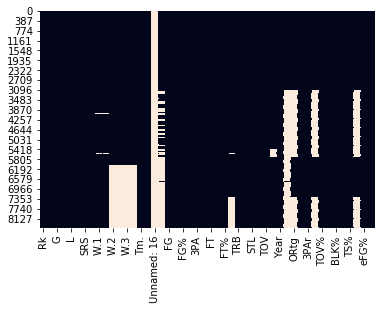

In [88]:
sns.heatmap(team_data_med.isnull(), cbar=False)

Several columns are just missing too many values (that are all clumped together, too). I'm dropping them.

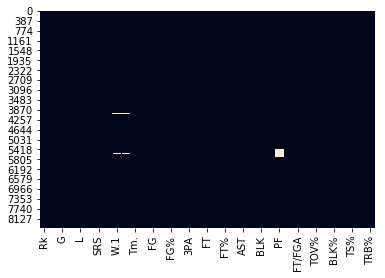

In [90]:
drop_cols=['W.2','L.2','W.3','L.3','Unnamed: 16','MP','ORB','Pace','ORB%','STL%','ORtg']#columns to drop
team_data_med=team_data_med.drop(columns=drop_cols)
sns.heatmap(team_data_med.isnull(), cbar=False)

Still a few missing, but I'm going to move on for now.

In [95]:
team_data_fat.to_csv('team_data_fat.csv',index=False,header=True)
team_data_med.to_csv('team_data_med.csv',index=False,header=True)


<a id='final'></a>

### Final datasets

In this section, I want to finalize the three datasets to use in the project: data_fat, data_med, and data_skinny. I'll start by merging player data with team data for data_fat.

In [123]:
data_fat=data[data.Year > 2009]#players with fat team data
team_data_fat=pd.read_csv('team_data_fat.csv',header=0)#read file back in for convenience

In [124]:
team_data_fat['college_code'] = to_college_code(team_data_fat.School)#create college_code column for merging

#school names are a little different in the team data, so there's a couple more things to do to get the right college abbreviations
team_data_fat['college_code']=team_data_fat['college_code'].str.replace('(','')
team_data_fat['college_code']=team_data_fat['college_code'].str.replace(')','')
team_data_fat['college_code']=team_data_fat['college_code'].str.replace('UC-','CALIFORNIA-')
team_data_fat['college_code']=team_data_fat['college_code'].str.replace('-&','')


In [125]:
team_data_fat.columns=['team_' + col for col in team_data_fat.columns]#since many columns have identical names between player and team data, this will differentiate
data_fat=data_fat.merge(team_data_fat, how='left',left_on=['Year','college_code'],right_on=['team_Year','team_college_code'])#merge on both year and college_code
data_fat=data_fat.drop(columns=['team_Rk','team_School','team_Year','team_college_code'])#drop columns that were only needed for merging

In [126]:
data_fat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 400
Columns: 170 entries, Player to team_opp_FT/FGA
dtypes: float64(165), int64(1), object(4)
memory usage: 535.7+ KB


Time to clean up missing values. 

In [127]:
fat_missing_cols=list(filter(lambda col: data_fat[col].isnull().sum()>0, data_fat.columns))#list of columns with missing values

fat_missing={}#dictionary to map columns to number of missing values
for col in fat_missing_cols:
    fat_missing[col]=data_fat[col].isnull().sum()#record number of missing values for each column
fat_missing

{'cfirst_assist_percentage': 28,
 'cfirst_block_percentage': 28,
 'cfirst_box_plus_minus': 126,
 'cfirst_defensive_box_plus_minus': 126,
 'cfirst_defensive_rebound_percentage': 88,
 'cfirst_offensive_box_plus_minus': 126,
 'cfirst_offensive_rebound_percentage': 88,
 'cfirst_player_efficiency_rating': 98,
 'cfirst_points_produced': 88,
 'cfirst_steal_percentage': 88,
 'cfirst_total_rebound_percentage': 28,
 'cfirst_usage_percentage': 28,
 'clast_box_plus_minus': 47,
 'clast_defensive_box_plus_minus': 47,
 'clast_offensive_box_plus_minus': 47,
 'clast_player_efficiency_rating': 47,
 'team_G': 1,
 'team_W': 1,
 'team_L': 1,
 'team_W-L%': 1,
 'team_SRS': 1,
 'team_SOS': 1,
 'team_W.1': 1,
 'team_L.1': 1,
 'team_W.2': 1,
 'team_L.2': 1,
 'team_W.3': 1,
 'team_L.3': 1,
 'team_Tm.': 1,
 'team_Opp.': 1,
 'team_MP': 1,
 'team_FG': 1,
 'team_FGA': 1,
 'team_FG%': 1,
 'team_3P': 1,
 'team_3PA': 1,
 'team_3P%': 1,
 'team_FT': 1,
 'team_FTA': 1,
 'team_FT%': 1,
 'team_ORB': 1,
 'team_TRB': 1,
 'tea

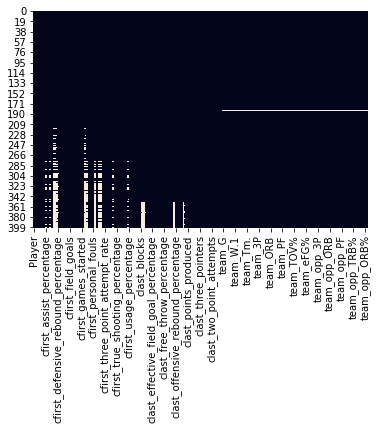

In [128]:
sns.heatmap(data_fat.isnull(), cbar=False)

Woof. That's a lot of ones! It looks like they're mostly in one row, too. Let's drop it.

In [129]:
data_fat=data_fat[~data_fat.team_G.isnull()]#drop the only row with missing team_G value


#recalculate missing values per column
fat_missing_cols=list(filter(lambda col: data_fat[col].isnull().sum()>0, data_fat.columns))

fat_missing={}
for col in fat_missing_cols:
    fat_missing[col]=data_fat[col].isnull().sum()
fat_missing

{'cfirst_assist_percentage': 28,
 'cfirst_block_percentage': 28,
 'cfirst_box_plus_minus': 126,
 'cfirst_defensive_box_plus_minus': 126,
 'cfirst_defensive_rebound_percentage': 88,
 'cfirst_offensive_box_plus_minus': 126,
 'cfirst_offensive_rebound_percentage': 88,
 'cfirst_player_efficiency_rating': 98,
 'cfirst_points_produced': 88,
 'cfirst_steal_percentage': 88,
 'cfirst_total_rebound_percentage': 28,
 'cfirst_usage_percentage': 28,
 'clast_box_plus_minus': 47,
 'clast_defensive_box_plus_minus': 47,
 'clast_offensive_box_plus_minus': 47,
 'clast_player_efficiency_rating': 47}

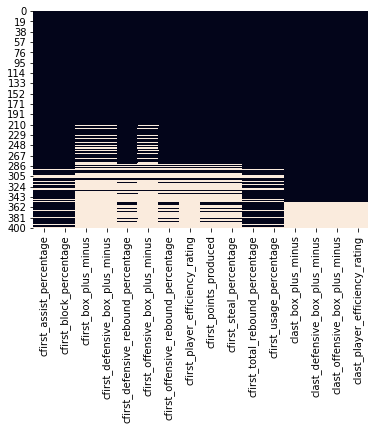

In [131]:
sns.heatmap(data_fat[fat_missing_cols].isnull(), cbar=False)

Much better. At this point I'm going to make the decision to keep the rows that are only missing box plus minus since I consider it valuable, and throw away all rows that are missing values in other columns.

The missing box plus minus values can reasonably be replaced with 0, since that represents a completely neutral contribution to team success. It is approximately the median, anyway.

In [134]:
for i in data_fat[data_fat.cfirst_box_plus_minus.isnull()].index:#fill in box_plus_minus missing values
    data_fat.loc[i,'cfirst_box_plus_minus']=0
    
for i in data_fat[data_fat.cfirst_defensive_box_plus_minus.isnull()].index:#fill in box_defensive_plus_minus missing values
    data_fat.loc[i,'cfirst_defensive_box_plus_minus']=0
    
for i in data_fat[data_fat.cfirst_offensive_box_plus_minus.isnull()].index:#fill in box_offensive_plus_minus missing values
    data_fat.loc[i,'cfirst_offensive_box_plus_minus']=0
    
data_fat=data_fat.dropna()#drop rows with any missing values
data_fat=data_fat.reset_index(drop=True)#reset index

Alright, data_fat is ready to go. I'll save it to a .csv file for later use.

In [160]:
data_fat.to_csv('data_fat.csv',index=False,header=True)#save to csv

Now I'm going to follow mostly the same steps to build data_med.

In [145]:
data_med=data[data.Year > 1992]#We're going back to 1993 this time
team_data_med=pd.read_csv('team_data_med.csv',header=0)

team_data_med['college_code'] = to_college_code(team_data_med.School)
team_data_med['college_code']=team_data_med['college_code'].str.replace('(','')
team_data_med['college_code']=team_data_med['college_code'].str.replace(')','')
team_data_med['college_code']=team_data_med['college_code'].str.replace('UC-','CALIFORNIA-')
team_data_med['college_code']=team_data_med['college_code'].str.replace('-&','')

team_data_med.columns=['team_' + col for col in team_data_med.columns]
data_med=data_med.merge(team_data_med, how='left',left_on=['Year','college_code'],right_on=['team_Year','team_college_code'])
data_med=data_med.drop(columns=['team_Rk','team_School','team_Year','team_college_code'])

In [147]:
med_missing_cols=list(filter(lambda col: data_med[col].isnull().sum()>0, data_med.columns))#list of missing columns

med_missing={}
for col in med_missing_cols:
    med_missing[col]=data_med[col].isnull().sum()
med_missing #dict with number of missing values for each column

{'cfirst_assist_percentage': 522,
 'cfirst_block_percentage': 522,
 'cfirst_box_plus_minus': 787,
 'cfirst_defensive_box_plus_minus': 787,
 'cfirst_defensive_rebound_percentage': 749,
 'cfirst_defensive_rebounds': 411,
 'cfirst_defensive_win_shares': 231,
 'cfirst_games_started': 266,
 'cfirst_minutes_played': 32,
 'cfirst_offensive_box_plus_minus': 787,
 'cfirst_offensive_rebound_percentage': 749,
 'cfirst_offensive_rebounds': 411,
 'cfirst_offensive_win_shares': 231,
 'cfirst_personal_fouls': 39,
 'cfirst_player_efficiency_rating': 759,
 'cfirst_points_produced': 749,
 'cfirst_steal_percentage': 740,
 'cfirst_total_rebound_percentage': 523,
 'cfirst_turnover_percentage': 40,
 'cfirst_turnovers': 40,
 'cfirst_usage_percentage': 522,
 'cfirst_win_shares': 231,
 'cfirst_win_shares_per_40_minutes': 263,
 'clast_assist_percentage': 463,
 'clast_block_percentage': 463,
 'clast_box_plus_minus': 708,
 'clast_defensive_box_plus_minus': 708,
 'clast_defensive_rebound_percentage': 661,
 'clast_

Many more missing values this time, but that was to be expected. Remember, I am planning on dropping columns to still include some team statistics but for many more rows than in data_fat.

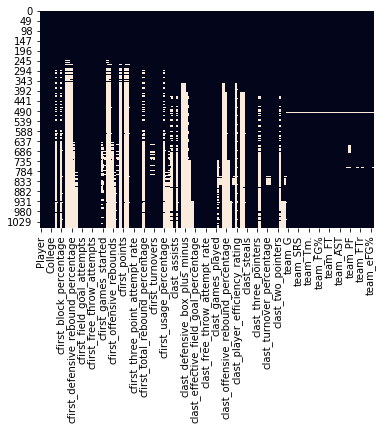

In [148]:
sns.heatmap(data_med.isnull(), cbar=False)

This is somewhat arbitrary, but I'm dropping all columns with more than 100 missing values.

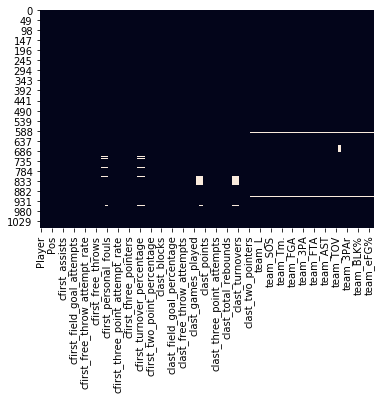

In [152]:
drop_cols=[]#columns to drop
for col in data_med.columns:#loop through all columns
    if data_med[col].isnull().sum() > 100:#check if more than 100 missing
        drop_cols.append(col)

data_med=data_med.drop(columns=drop_cols)#drop columns
sns.heatmap(data_med.isnull(), cbar=False)

And now, I'll drop all the rows that are still missing values. After that, data_med is ready to save for future use.

In [161]:
data_med=data_med.dropna()#drop rows
data_med=data_med.reset_index()#reset index
data_med.to_csv('data_med.csv',index=False,header=True)#save to csv

Only one more to go. And it's the easiest, too.

Remember, data_skinny is not going to contain any team_data. We'll make it as clean as we can using only individual player stats.

In [156]:
data_skinny=data#using all of the player data

skinny_missing_cols=list(filter(lambda col: data_skinny[col].isnull().sum()>0, data_skinny.columns))#list of cols with missing values

skinny_missing={}
for col in skinny_missing_cols:
    skinny_missing[col]=data_skinny[col].isnull().sum()
skinny_missing #dict of numbers of missing values per column

{'cfirst_assist_percentage': 656,
 'cfirst_block_percentage': 656,
 'cfirst_box_plus_minus': 931,
 'cfirst_defensive_box_plus_minus': 931,
 'cfirst_defensive_rebound_percentage': 893,
 'cfirst_defensive_rebounds': 555,
 'cfirst_defensive_win_shares': 375,
 'cfirst_games_started': 306,
 'cfirst_minutes_played': 32,
 'cfirst_offensive_box_plus_minus': 931,
 'cfirst_offensive_rebound_percentage': 893,
 'cfirst_offensive_rebounds': 555,
 'cfirst_offensive_win_shares': 375,
 'cfirst_personal_fouls': 39,
 'cfirst_player_efficiency_rating': 903,
 'cfirst_points_produced': 893,
 'cfirst_steal_percentage': 884,
 'cfirst_total_rebound_percentage': 657,
 'cfirst_turnover_percentage': 40,
 'cfirst_turnovers': 40,
 'cfirst_usage_percentage': 657,
 'cfirst_win_shares': 375,
 'cfirst_win_shares_per_40_minutes': 407,
 'clast_assist_percentage': 597,
 'clast_block_percentage': 597,
 'clast_box_plus_minus': 852,
 'clast_defensive_box_plus_minus': 852,
 'clast_defensive_rebound_percentage': 805,
 'clast_

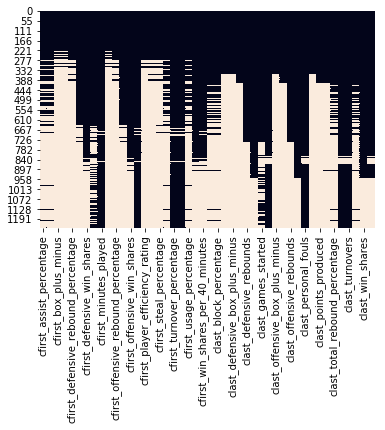

In [157]:
sns.heatmap(data_skinny[skinny_missing_cols].isnull(), cbar=False)

Using the same arbitrary threshold of 100 missing values as in data_med.

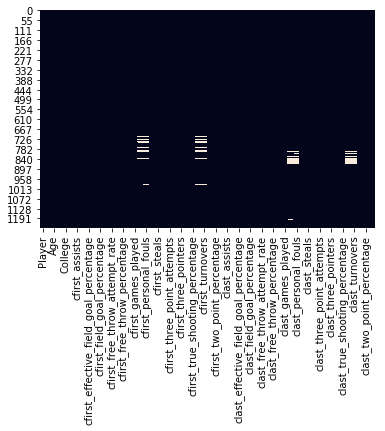

In [158]:
drop_cols=[]#list of columns to drop
for col in data_skinny.columns:
    if data_skinny[col].isnull().sum() > 100:#check if more than 100 missing
        drop_cols.append(col)

data_skinny=data_skinny.drop(columns=drop_cols)#drop columns
sns.heatmap(data_skinny.isnull(), cbar=False)

Just like before: drop rows, reset index, save.

In [162]:
data_skinny=data_skinny.dropna()
data_skinny=data_skinny.reset_index()
data_skinny.to_csv('data_skinny.csv',index=False,header=True)

Finally, I want to compare the shapes of the three different datasets.

In [164]:
data_fat.shape

(302, 170)

In [165]:
data_med.shape

(940, 93)

In [166]:
data_skinny.shape

(1124, 59)

As you can see, data_fat has only 302 rows but 170 feature columns. data_skinny has 1124 rows but only 59 columns. I expect data_med with its 940 columns and 93 features to be the most useful.